In [1]:
import pandas as pd
from pandasql import sqldf
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds_1 = pd.read_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/cart_items_amended.csv")
ds_1.drop(['Unnamed: 0'], axis=1, inplace = True)
ds_1.head()

,loan_application_id,name,price,quantity
0,7397173,Смартфон Apple iPhone 8 Plus 64GB Space Gray (...,44990.0,1
1,7397173,Чехол для iPhone Apple iPhone 8 Plus / 7 Plus ...,2990.0,1
2,7397174,Телевизор LG 32LK510,14990.0,1
3,7397177,Ноутбук Apple MacBook Air 13 i5 1.8/8Gb/128SSD...,64490.0,1
4,7397197,"Стиральная машина CANDY CS4 1051D1/2-07, фронт...",12470.0,1


In [3]:
ds_1[ds_1["loan_application_id"] == 10565286]

,loan_application_id,name,price,quantity


In [4]:
ds_2 = pd.read_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/apps.csv",sep=';', engine="python", encoding='cp1251')

In [5]:
ds_2.head()

,target,loan_application_id,client_id,loan_application_key,previous_application_with_fico_key,federal_region_nm,city_nm,chain_nm,first_chain_nm,first_store_nm,...,application_dttm,application_amt,application_repeat_type,approved_flg,conversion_flg,loan_key,loan_order_num,start_dt,principal_amt,birth_dt
0,NaN,10566042,4272096,10518421,10510793,Волгоградская область,Волгоград,Eldorado DirectCredit pick-up,Mvideo DirectCredit pick-up,PUMVD390YUG,...,2020-03-31 10:47:47,1,preapplication,0,0,NaN,0,NaN,NaN,1994-05-19
1,NaN,10566033,4272187,10518412,10518412,Томская область,Томск,Mvideo DirectCredit pick-up,Mvideo DirectCredit pick-up,PUMVD642SIB,...,2020-03-31 10:47:09,1,preapplication,1,0,NaN,0,NaN,NaN,1978-11-03
2,NaN,10566031,4272184,10518410,10518410,г. Москва,Москва,Рево Client App,Рево Client App,Рево Client App,...,2020-03-31 10:47:07,1,preapplication,1,0,NaN,0,NaN,NaN,1996-11-05
3,NaN,10566028,4272118,10518407,10510936,г. Москва,Москва,Рево Client App,Детский Мир,DM1632VOL,...,2020-03-31 10:47:00,1,preapplication,0,0,NaN,1,NaN,NaN,1989-09-26
4,NaN,10566026,4272186,10518405,10518405,Свердловская область,Екатеринбург,Eldorado DirectCredit pick-up,Eldorado DirectCredit pick-up,PUELA671URL,...,2020-03-31 10:46:51,1,preapplication,0,0,NaN,0,NaN,NaN,1998-11-30


# Data cleaning and merging

In [6]:
dataset = sqldf(
'''
SELECT
    DS2.*
    ,DS1.quantity
    ,DS1.total_price
    ,DS1.min_price
    ,DS1.max_price
    ,DS1.avg_price
FROM
    ds_2 DS2
LEFT JOIN
(
    SELECT
        loan_application_id
        ,SUM(quantity) AS quantity
        ,SUM(price) AS total_price
        ,MIN(price) AS min_price
        ,MAX(price) AS max_price
        ,AVG(price) AS avg_price
    FROM
        ds_1
    GROUP BY
        loan_application_id
) DS1
ON
    DS2.loan_application_id = DS1.loan_application_id
'''
)

In [7]:
#bin_labels_5 = ['A_amt', 'B_amt', 'C_amt', 'D_amt', 'E_amt']
dataset['application_amt'] = dataset['application_amt'].apply(lambda x: x.replace(',','.'))
dataset['application_amt'] = pd.to_numeric(dataset['application_amt'])
#dataset['principal_amt'] = dataset['principal_amt'].notnull().apply(lambda x: x.replace(',','.'))
dataset['principal_amt'] = dataset['principal_amt'].apply(lambda x: x.replace(',','.') if(pd.notnull(x)) else x)
dataset['principal_amt'] = pd.to_numeric(dataset['principal_amt'])    
#dataset['amt_quartiles'] = pd.qcut(dataset['application_amt'], 5, labels=bin_labels_5)

In [8]:
#Remove garbage
dataset = dataset[(dataset["birth_dt"] >= "1941-07-04") & (dataset["birth_dt"] < "2300-01-01")]
#Generate age
dataset['application_dttm'] = pd.to_datetime(dataset['application_dttm'])
dataset['birth_dt'] = pd.to_datetime(dataset['birth_dt'])
dataset["borrower_age_yy"] = (dataset['application_dttm'] - dataset['birth_dt'])
dataset["borrower_age_yy"] = ((dataset["borrower_age_yy"] / np.timedelta64(1, 'D')).astype(int)/365.25).astype(float)

In [9]:
print(dataset["borrower_age_yy"].min())
print(dataset["borrower_age_yy"].max())

-0.7912388774811773
78.64202600958248


In [10]:
#Сколько денег не хватило в абс и в %%
dataset["money_shortage_amt"] = dataset["total_price"] - dataset["application_amt"]
dataset["money_shortage_perc"] = dataset["money_shortage_amt"]/dataset["total_price"]

In [11]:
dataset.count()

target                                  82662
loan_application_id                   1164811
client_id                             1164811
loan_application_key                  1164811
previous_application_with_fico_key    1164811
federal_region_nm                     1163936
city_nm                               1161477
chain_nm                              1164811
first_chain_nm                        1164811
first_store_nm                        1164811
channel_type                          1164811
application_dttm                      1164811
application_amt                       1164811
application_repeat_type               1164811
approved_flg                          1164811
conversion_flg                        1164811
loan_key                                82662
loan_order_num                        1164811
start_dt                                82662
principal_amt                           82662
birth_dt                              1164811
quantity                          

In [12]:
dataset[(dataset["target"].notnull() & dataset["quantity"].isnull() )]

,target,loan_application_id,client_id,loan_application_key,previous_application_with_fico_key,federal_region_nm,city_nm,chain_nm,first_chain_nm,first_store_nm,...,principal_amt,birth_dt,quantity,total_price,min_price,max_price,avg_price,borrower_age_yy,money_shortage_amt,money_shortage_perc
7,0.0,10565788,4162588,10518384,10137391,г. Москва,Москва,Lamoda,Lamoda,Lamoda (узнать лимит),...,14938.00,1986-09-06,NaN,NaN,NaN,NaN,NaN,33.566051,NaN,NaN
23,0.0,10565286,4272015,10518320,10510537,Кемеровская область,Новокузнецк,O'Hara,O'Hara,OHR1098SIB,...,5458.18,1952-11-06,NaN,NaN,NaN,NaN,NaN,67.397673,NaN,NaN
27,0.0,10565048,4271961,10518303,10510325,Кемеровская область,Кемерово,585,585,PVP2267SIB,...,10947.00,1997-09-19,NaN,NaN,NaN,NaN,NaN,22.529774,NaN,NaN
320,0.0,10572101,4007039,10517256,9650496,г. Москва,Москва,Ennergiia,Рево Client App,Рево Client App,...,6562.00,1995-04-17,NaN,NaN,NaN,NaN,NaN,24.955510,NaN,NaN
497,0.0,10571517,4195101,10516672,10245322,Краснодарский край,Анапа,Детский Мир,Детский Мир,DM1642YUG,...,5796.00,1955-08-18,NaN,NaN,NaN,NaN,NaN,64.618754,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165271,0.0,7283957,3056906,7233056,7233418,Хабаровский край,Комсомольск-на-Амуре,585,585,PVP2134VOS,...,7433.00,1994-10-25,NaN,NaN,NaN,NaN,NaN,24.933607,NaN,NaN
1165298,0.0,7283800,3051960,7232960,7233753,Республика Бурятия,Улан-Удэ,Unichel,Unichel,UNI1723URL,...,6425.00,1961-07-28,NaN,NaN,NaN,NaN,NaN,58.176591,NaN,NaN
1165320,0.0,7283527,2973257,7232887,7061214,г. Москва,Москва,Mvideo DirectCredit pick-up,Mvideo DirectCredit pick-up,PUMVD084MOS,...,26453.70,1989-08-12,NaN,NaN,NaN,NaN,NaN,30.135524,NaN,NaN
1165330,0.0,7283426,2485289,7232869,5662310,г. Москва,Москва,Mvideo DirectCredit pick-up,Mvideo DirectCredit pick-up,PUMVD020MOS,...,29990.00,1997-05-22,NaN,NaN,NaN,NaN,NaN,22.360027,NaN,NaN


# Numerical features

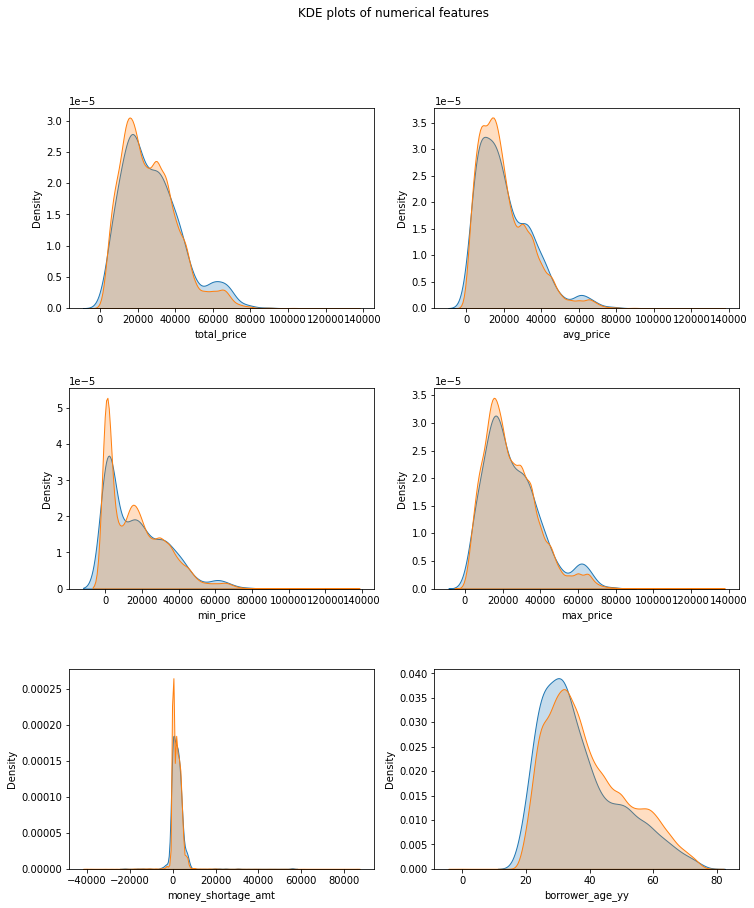

In [13]:
import warnings
warnings.filterwarnings("ignore")
numerical_cols = ["total_price", "avg_price", "min_price", "max_price", "money_shortage_amt", "borrower_age_yy"]
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (12,14))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
fig.suptitle("KDE plots of numerical features")

for ax, col in zip(axes.flatten(), numerical_cols) :
    sns.kdeplot(dataset[(dataset["application_repeat_type"] != "preapplication") & ( dataset["target"] == 1)][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(dataset[(dataset["application_repeat_type"] != "preapplication") & ( dataset["target"] == 0)][col], shade="True", label="Rejected", ax = ax)
    ax.set_xlabel(col)

# Categorical features with low cardinality

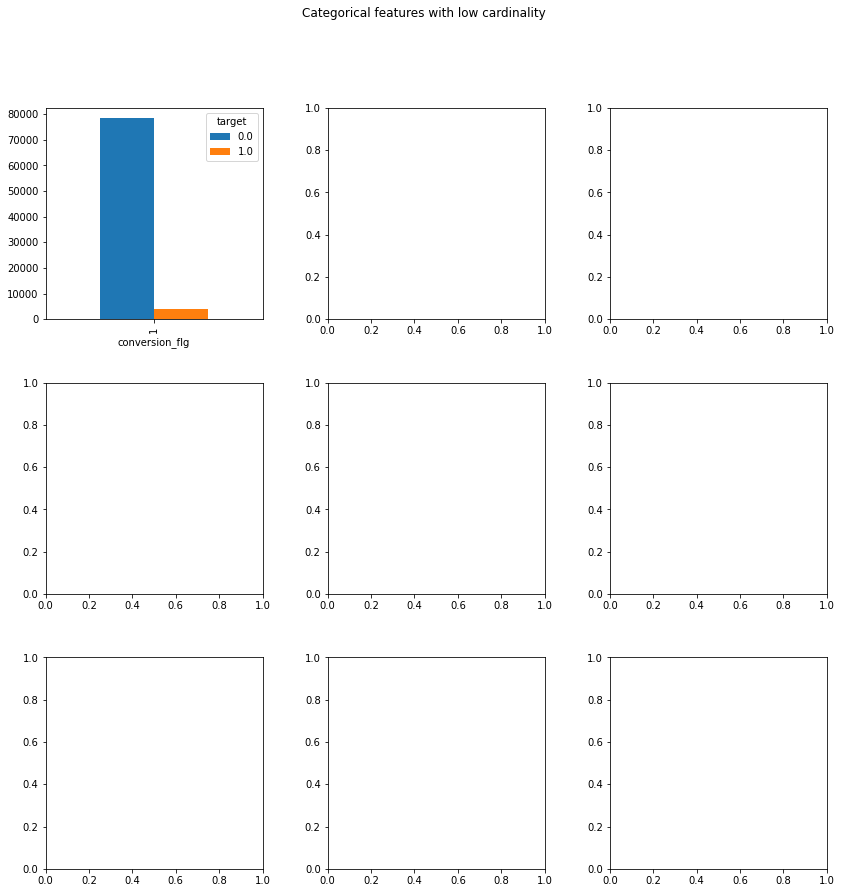

In [14]:
cat_cols_few = ["conversion_flg"]


fig, axes = plt.subplots(ncols = 3, nrows = 3, figsize = (14,14))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with low cardinality")

for ax, col in zip(axes.flatten(), cat_cols_few) :
    pd.crosstab(dataset[col], dataset["target"]).plot(kind="bar", ax = ax)
    ax.set_xlabel(col)

# Categorical features with high cardinality

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

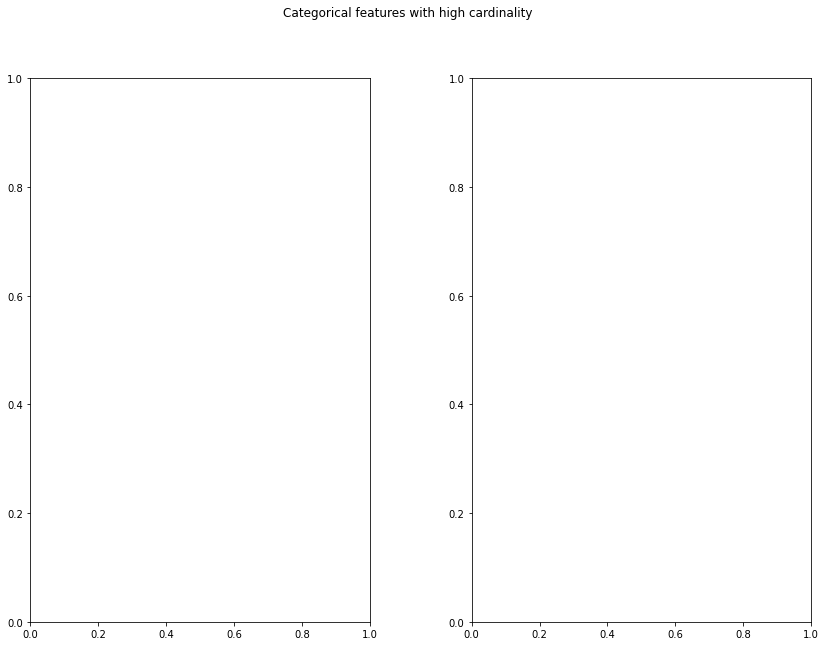

In [14]:
cat_cols_many = ["city_nm"]

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (14,10))
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
fig.suptitle("Categorical features with high cardinality")

for ax, col in zip(axes.flatten(), cat_cols_many) :
    sns.kdeplot(dataset[dataset["target"] == 0][col], shade="True", label="Not accepted", ax = ax)
    sns.kdeplot(dataset[dataset["target"] == 1][col], shade="True", label="Accepted", ax = ax)
    ax.set_xlabel(col)

In [15]:
df_train = dataset[dataset["target"].notnull()]

In [16]:
df_train.count()

target                                82662
loan_application_id                   82662
client_id                             82662
loan_application_key                  82662
previous_application_with_fico_key    82662
federal_region_nm                     82648
city_nm                               82571
chain_nm                              82662
first_chain_nm                        82662
first_store_nm                        82662
channel_type                          82662
application_dttm                      82662
application_amt                       82662
application_repeat_type               82662
approved_flg                          82662
conversion_flg                        82662
loan_key                              82662
loan_order_num                        82662
start_dt                              82662
principal_amt                         82662
birth_dt                              82662
quantity                              18847
total_price                     

# Cleaning

In [17]:
to_drop = ["loan_application_id", "client_id", "approved_flg",
           "loan_application_key", "previous_application_with_fico_key", "city_nm" , "first_chain_nm", "first_store_nm", "application_dttm", "loan_key","start_dt", "birth_dt"]
df_train.drop(to_drop, axis=1, inplace=True)

In [18]:
df_train.count()

target                     82662
federal_region_nm          82648
chain_nm                   82662
channel_type               82662
application_amt            82662
application_repeat_type    82662
conversion_flg             82662
loan_order_num             82662
principal_amt              82662
quantity                   18847
total_price                18847
min_price                  18847
max_price                  18847
avg_price                  18847
borrower_age_yy            82662
money_shortage_amt         18847
money_shortage_perc        18847
dtype: int64

In [19]:
cat_cols_few = ["federal_region_nm", "chain_nm",
            "channel_type","application_repeat_type"]#, "amt_quartiles"]
for col in cat_cols_few:
        df_train[col].fillna(df_train[col].mode()[0], inplace=True)
df_train = pd.get_dummies(df_train, columns = cat_cols_few)

In [20]:
df_train.count()

target                                  82662
application_amt                         82662
conversion_flg                          82662
loan_order_num                          82662
principal_amt                           82662
                                        ...  
channel_type_Full_online                82662
channel_type_Offline                    82662
channel_type_Online                     82662
application_repeat_type_false repeat    82662
application_repeat_type_new             82662
Length: 152, dtype: int64

In [21]:
df_train["target"] = (df_train["target"]).astype(int)
df_train

,target,application_amt,conversion_flg,loan_order_num,principal_amt,quantity,total_price,min_price,max_price,avg_price,...,chain_nm_Перевод на карту,chain_nm_Связной,chain_nm_Связной Онлайн,chain_nm_Сеть отсутствует в ChainLookup,chain_nm_Точка Зрения Пермь,channel_type_Full_online,channel_type_Offline,channel_type_Online,application_repeat_type_false repeat,application_repeat_type_new
7,0,14938.00,1,1,14938.00,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0
23,0,5458.18,1,1,5458.18,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,1
27,0,10947.00,1,1,10947.00,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,1
70,0,23990.00,1,1,23990.00,1.0,23990.0,23990.0,23990.0,23990.0,...,0,0,0,0,0,0,0,1,1,0
92,0,44181.00,1,1,44181.00,3.0,44181.0,0.0,26591.0,14727.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165271,0,7433.00,1,1,7433.00,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,1
1165298,0,6425.00,1,1,6425.00,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,1
1165320,0,26453.70,1,1,26453.70,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0
1165330,0,29990.00,1,1,29990.00,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,1,0


# Modelling

In [22]:
# Divide in training/validation and test data
stratified = True
num_folds = 5
df = df_train
print("Starting XGBoost. Train shape: {}".format(df.shape))
    #gc.collect()
    # Cross validation model
if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    #oof_preds = np.zeros(df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in df.columns if f not in ["target"]]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df["target"])):
    train_x, train_y = df[feats].iloc[train_idx], df["target"].iloc[train_idx]
    valid_x, valid_y = df[feats].iloc[valid_idx], df["target"].iloc[valid_idx]
    print("Fold training")
    xgboost_model = XGBClassifier(
            #tree_method='gpu_hist', 
            #gpu_id=1,
            base_score=0.5, 
            booster='gbtree', 
            colsample_bylevel=1,
            colsample_bytree=0.6, 
            gamma=0, 
            learning_rate=0.02, 
            max_delta_step=0,
            max_depth=8, 
            min_child_weight=8, 
            missing=None, 
            n_estimators=1000,
            n_jobs=16, 
            nthread=None, 
            objective='binary:logistic', 
            random_state=0,
            reg_alpha=0.2, 
            reg_lambda=1, 
            scale_pos_weight=1, 
            seed=None,
            #silent=True, 
            subsample=0.7
    )
       # xgboost_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
       #         eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

       #     oof_preds[valid_idx] = xgboost_model.predict_proba(valid_x, num_iteration=xgboost_model.best_iteration_)[:, 1]
        #    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        #prediction = xgboost_model.predict(train_y)
    xgboost_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= 200, early_stopping_rounds= 400)


Starting XGBoost. Train shape: (82662, 152)
Fold training
[0]	validation_0-auc:0.64243	validation_1-auc:0.62870
[200]	validation_0-auc:0.75494	validation_1-auc:0.69075
[400]	validation_0-auc:0.77663	validation_1-auc:0.69278
[600]	validation_0-auc:0.79554	validation_1-auc:0.69122
[777]	validation_0-auc:0.80717	validation_1-auc:0.68850
Fold training
[0]	validation_0-auc:0.62418	validation_1-auc:0.63556
[200]	validation_0-auc:0.75189	validation_1-auc:0.70652
[400]	validation_0-auc:0.77543	validation_1-auc:0.70427
[576]	validation_0-auc:0.78970	validation_1-auc:0.69947
Fold training
[0]	validation_0-auc:0.63319	validation_1-auc:0.63392
[200]	validation_0-auc:0.75076	validation_1-auc:0.70822
[400]	validation_0-auc:0.77370	validation_1-auc:0.71009
[600]	validation_0-auc:0.79192	validation_1-auc:0.70919
[798]	validation_0-auc:0.80707	validation_1-auc:0.70691
Fold training
[0]	validation_0-auc:0.64544	validation_1-auc:0.62819
[200]	validation_0-auc:0.75611	validation_1-auc:0.68811
[400]	valida

In [23]:
np.mean([0.69278,0.70652,0.71009,0.68811,0.69588])

0.6986760000000001

In [ ]:
stratified = True
num_folds = 5
train_df = df_train
# Divide in training/validation and test data
print("Starting LightGBM. Train shape: {}, test shape: {}")#.format(df.shape, test_df.shape))
#gc.collect()
    # Cross validation model
if stratified:
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
else:
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['target']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["target"])):
    train_x, train_y = train_df[feats].iloc[train_idx], train_df["target"].iloc[train_idx]
    valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["target"].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
            boosting_type= 'goss',
            nthread=4,
            n_estimators=100,#10000,
            learning_rate=0.005134,
            num_leaves=54,
            colsample_bytree=0.508716,
            subsample=1,
            subsample_for_bin= 240000,
            max_depth=10,
            reg_alpha=0.436193,
            reg_lambda=0.436193,
            min_split_gain=0.024766,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    del clf, train_x, train_y, valid_x, valid_y
    #gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))
    # Write submission file and plot feature importance
    #if not debug:
    #    test_df['TARGET'] = sub_preds
    #    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    #display_importances(feature_importance_df)
    #return feature_importance_df

Starting LightGBM. Train shape: {}, test shape: {}
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.712336	training's binary_logloss: 0.192319	valid_1's auc: 0.673042	valid_1's binary_logloss: 0.19374
Fold  1 AUC : 0.673042
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	training's auc: 0.710001	training's binary_logloss: 0.192751	valid_1's auc: 0.68645	valid_1's binary_logloss: 0.193545
Fold  2 AUC : 0.686450
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Did not meet ea

In [25]:
print('Full AUC score %.6f' % roc_auc_score(train_df['target'], oof_preds))

Full AUC score 0.679408


In [55]:
sum(train_x.isnull())

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [49]:
xgboost_model.predict(train_x)

XGBoostError: [00:18:04] ../src/c_api/c_api_utils.h:161: Invalid missing value: null
Stack trace:
  [bt] (0) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7fc9af5b533f]
  [bt] (1) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9c811) [0x7fc9af5c0811]
  [bt] (2) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9cac0) [0x7fc9af5c0ac0]
  [bt] (3) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDense+0x225) [0x7fc9af5a8005]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7fca51eecff5]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7fca51eec40a]
  [bt] (6) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x58c) [0x7fca50f9429c]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x137d0) [0x7fca50f947d0]
  [bt] (8) /home/amadeus/Yury_env/Yury_env/bin/python(_PyObject_MakeTpCall+0x296) [0x5f66f6]



In [43]:
def kfold_XBG(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    print("Starting XGBoost. Train shape: {}".format(df.shape))
    #gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    #oof_preds = np.zeros(df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in df.columns if f not in ["target"]]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df["target"])):
        train_x, train_y = df[feats].iloc[train_idx], df["target"].iloc[train_idx]
        valid_x, valid_y = df[feats].iloc[valid_idx], df["target"].iloc[valid_idx]

    xgboost_model = XGBClassifier(
        tree_method='gpu_hist', 
        gpu_id=1,
        base_score=0.5, 
        booster='gbtree', 
        colsample_bylevel=1,
        colsample_bytree=0.6, 
        gamma=0, 
        learning_rate=0.02, 
        max_delta_step=0,
        max_depth=8, 
        min_child_weight=8, 
        missing=None, 
        n_estimators=10000,
        n_jobs=1, 
        nthread=None, 
        objective='binary:logistic', 
        random_state=0,
        reg_alpha=0.2, 
        reg_lambda=1, 
        scale_pos_weight=1, 
        seed=None,
        silent=True, 
        subsample=0.7
    )

   # xgboost_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
   #         eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

   #     oof_preds[valid_idx] = xgboost_model.predict_proba(valid_x, num_iteration=xgboost_model.best_iteration_)[:, 1]
    #    sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        
    #prediction = xgboost_model.predict(train_y)
    xgboost_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    #prediction = xgboost_model.predict_proba(valid_x)
        #sub_preds += xgboost_model.predict_proba(test_df[feats], num_iteration=xgboost_model.best_iteration_)[:, 1] / folds.n_splits
    return xgboost_model# prediction, valid_y

In [44]:
model = kfold_XBG(dataset,5,True,True)

Starting XGBoost. Train shape: (82571, 143)


/home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:15:20] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62043	validation_1-auc:0.61603
[200]	validation_0-auc:0.71297	validation_1-auc:0.67679
[383]	validation_0-auc:0.72551	validation_1-auc:0.67504


In [45]:
model.predict_proba()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=8,
              min_child_weight=8, missing=None, monotone_constraints='()',
              n_estimators=600, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=True, subsample=0.7, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [42]:
prediction, valid_y = kfold_XBG(dataset,5,True,True)

Starting XGBoost. Train shape: (82571, 143)


/home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:13:46] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.62043	validation_1-auc:0.61603
[200]	validation_0-auc:0.71297	validation_1-auc:0.67679
[383]	validation_0-auc:0.72551	validation_1-auc:0.67504


XGBoostError: [00:13:49] ../src/c_api/c_api_utils.h:161: Invalid missing value: null
Stack trace:
  [bt] (0) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9133f) [0x7fc9af5b533f]
  [bt] (1) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9c811) [0x7fc9af5c0811]
  [bt] (2) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x9cac0) [0x7fc9af5c0ac0]
  [bt] (3) /home/amadeus/Yury_env/Yury_env/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDense+0x225) [0x7fc9af5a8005]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7fca51eecff5]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7fca51eec40a]
  [bt] (6) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x58c) [0x7fca50f9429c]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x137d0) [0x7fca50f947d0]
  [bt] (8) /home/amadeus/Yury_env/Yury_env/bin/python(_PyObject_MakeTpCall+0x296) [0x5f66f6]



In [ ]:
print('The accuracy is:', metrics.accuracy_score(y_test, prediction))
print("\n")
print("Classification Report:")
print(metrics.classification_report(y_test, prediction))

sns.heatmap(confusion_matrix(y_test, prediction), annot=True)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(df.shape, test_df.shape))
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df["target"])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df["target"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["target"].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            boosting_type= 'goss',
            nthread=4,
            n_estimators=100,#10000,
            learning_rate=0.005134,
            num_leaves=54,
            colsample_bytree=0.508716,
            subsample=1,
            subsample_for_bin= 240000,
            max_depth=10,
            reg_alpha=0.436193,
            reg_lambda=0.436193,
            min_split_gain=0.024766,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [ ]:
to_log = ["loan_amount", "applicant_income", "number_of_owner-occupied_units",
          "number_of_1_to_4_family_units", "minority_population"]

to_drop = ["row_id", "number_of_1_to_4_family_units",
           "occupancy", "preapproval", "county_code"]

num_cols = ["loan_amount", "applicant_income", "population", "minority_population_pct",
            "ffiecmedian_family_income", "tract_to_msa_md_income_pct",
            "number_of_owner-occupied_units"]

cat_cols_few = ["loan_type", "property_type", "loan_purpose",
            "applicant_ethnicity", "applicant_race",
            "applicant_sex", "co_applicant"]

def prepare_data(df):
    
    df["co_applicant"] = df["co_applicant"].astype("int8")
    df.replace(replace_dict, np.nan, inplace = True)
    
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
        
    for col in cat_cols_few:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
    df["minority_population"] = (df["minority_population_pct"] / 100) * (df["population"])
    df["tract_family_income"] = (df["tract_to_msa_md_income_pct"] / 100) * (df["ffiecmedian_family_income"])

    df[to_log] = df[to_log].applymap(math.log)
    
    to_drop.extend(["minority_population_pct", "population",
                    "ffiecmedian_family_income", "tract_to_msa_md_income_pct"])
    df.drop(to_drop, axis=1, inplace=True)
    
    df = pd.get_dummies(df, columns = cat_cols_few)
    
    return df

# Commented

In [32]:
'''
loan_application_id = []
name = []
price = []
quantity = []

with tqdm(total=ds_1.shape[0]) as pbar:
    for _, row in ds_1.iterrows():
        pbar.update(1)
        ds_json = pd.DataFrame.from_dict(row["cart_items"])
        for i in range(0,ds_json.shape[0]):
            loan_application_id.append(row["loan_application_id"])
            name.append(ds_json["name"][i])
            price.append(ds_json["price"][i])
            quantity.append(ds_json["quantity"][i])

        #print(ds_json.shape)
        #print(ds_json)
        #break
'''

100%|██████████| 1654637/1654637 [15:47<00:00, 1745.68it/s]


In [29]:
ds_1 = pd.read_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/cart_items.csv",sep=";")

In [30]:
ds_1['cart_items']=ds_1['cart_items'].apply(lambda x:eval(x))

In [32]:
ds_1['cart_items'][0]

[{'name': 'Смартфон Apple iPhone 8 Plus 64GB\xa0Space Gray (MQ8L2RU/A)',
  'price': '44990',
  'quantity': '1'},
 {'name': 'Чехол для iPhone Apple iPhone 8 Plus / 7 Plus Silicone Black (MQGW2ZM/A)',
  'price': '2990',
  'quantity': '1'}]

In [33]:
ds_1[ds_1["loan_application_id"] == 10565286]

,loan_application_id,cart_items


In [33]:
ds_1_amended = pd.DataFrame(list(zip(loan_application_id, name,price,quantity)),
               columns =['loan_application_id', 'name', 'price', 'quantity'])

In [15]:
sqldf(
    '''
SELECT 
    federal_region_nm
    ,SUM(target) AS event
    ,COUNT(target) AS total_events
    ,SUM(target)/COUNT(target) AS event_rate
    ,(COUNT(target) ) AS perc
    ,(SELECT COUNT(target) FROM DS_EDA) AS total
FROM 
    DS_EDA
GROUP BY
    federal_region_nm
ORDER BY
    total_events DESC        
''')

,federal_region_nm,event,total_events,event_rate,perc,total
0,г. Москва,808.0,13706,0.058952,13706,82673
1,Московская область,265.0,4927,0.053785,4927,82673
2,Кемеровская область,111.0,3449,0.032183,3449,82673
3,Краснодарский край,211.0,3339,0.063193,3339,82673
4,Новосибирская область,88.0,3172,0.027743,3172,82673
...,...,...,...,...,...,...
75,Ямало-Ненецкий автономный округ,7.0,38,0.184211,38,82673
76,Камчатский край,1.0,36,0.027778,36,82673
77,Еврейская автономная область,1.0,14,0.071429,14,82673
78,None,3.0,14,0.214286,14,82673


In [24]:
sqldf(
'''
SELECT
    target
    ,application_repeat_type
    ,COUNT(*) AS CNT
FROM
    ds_2
GROUP BY
    target
    ,application_repeat_type
'''
)

sqldf(
'''

SELECT
    client_id
    ,COUNT(client_id) client_count
    ,sum(target) tar
FROM
    AGGREGATED_DS
GROUP BY
    client_id
ORDER BY
    client_count
'''
)

sqldf(
'''
SELECT
    *
FROM
    AGGREGATED_DS
WHERE
    1 = 1
    AND client_id = 601729
'''
)

,client_id,client_count,sum(target)
0,22872,1,NaN
1,38866,1,NaN
2,69080,1,NaN
3,72911,1,0.0
4,78191,1,NaN
...,...,...,...
1091606,601729,18,NaN
1091607,2567924,18,NaN
1091608,279502,20,NaN
1091609,2327833,24,NaN


In [36]:
ds_1_amended.to_csv("/home/amadeus/Desktop/kaggle/Yury/Mokka_test/input_data/cart_items_amended.csv")

In [16]:
sqldf(
    '''
select 
    channel_type
    ,sum(target) as event
    ,count(target) as total_events
    ,sum(target)/count(target) as event_rate
    ,(count(target) ) as perc
    ,(select count(target) from DS_EDA) as total
from 
    DS_EDA
group by
    channel_type
order by
    total_events desc        
''')

,channel_type,event,total_events,event_rate,perc,total
0,Offline,2891.0,62492,0.046262,62492,82673
1,Online,967.0,17166,0.056332,17166,82673
2,Full_online,271.0,3015,0.089884,3015,82673


In [17]:
sqldf(
    '''
select 
    birth_dt
    ,sum(target) as event
    ,count(target) as total_events
    ,sum(target)/count(target) as event_rate
    ,(count(target) ) as perc
    ,(select count(target) from DS_EDA) as total
from 
    DS_EDA
group by
    birth_dt
order by
    total_events desc        
''')

,birth_dt,event,total_events,event_rate,perc,total
0,1987-11-03,0.0,20,0.000000,20,82673
1,1988-10-04,0.0,19,0.000000,19,82673
2,1987-01-09,1.0,19,0.052632,19,82673
3,1986-11-07,0.0,19,0.000000,19,82673
4,1990-04-17,2.0,18,0.111111,18,82673
...,...,...,...,...,...,...
18260,1941-07-04,0.0,1,0.000000,1,82673
18261,1884-07-19,0.0,1,0.000000,1,82673
18262,1198-06-21,0.0,1,0.000000,1,82673
18263,1070-03-11,0.0,1,0.000000,1,82673
